Global seed set to 42 for reproducibility.

--- Original DataFrame Head ---
         Date Symbol      Open      High       Low     Close     Volume
0  08-01-1998   AAPL  0.131018  0.139940  0.127261  0.136652  774020800
1  09-01-1998   AAPL  0.136183  0.145575  0.131487  0.136652  886547200
2  12-01-1998   AAPL  0.131017  0.139940  0.128670  0.137122  516398400
3  13-01-1998   AAPL  0.139940  0.147453  0.139001  0.146514  636854400
4  14-01-1998   AAPL  0.149331  0.149801  0.144636  0.148392  589265600

--- DataFrame Head after Date Conversion and Sorting ---
        Date Symbol      Open      High       Low     Close     Volume
0 1998-01-08   AAPL  0.131018  0.139940  0.127261  0.136652  774020800
1 1998-01-08   ADBE  5.136538  5.275363  5.121113  5.205951    8851200
2 1998-01-08    AMD  9.531250  9.843750  9.375000  9.468750    3452400
3 1998-01-08   AMGN  9.183955  9.248783  9.140737  9.227174    4592800
4 1998-01-08   AMZN  0.234896  0.235156  0.226563  0.230729  120312000

--- Dat

Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 64)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 1, 64)     │          0 │ input_layer[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 64)     │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     33,216 │

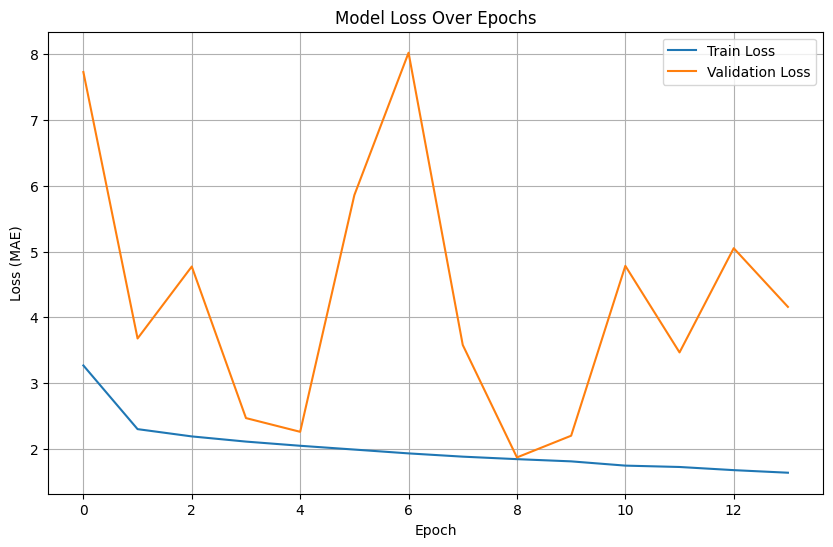


Code execution complete with detailed analysis and metrics.


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import random
import os
import scipy
from scipy import stats
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow import keras

# ==============================================================================
## 1. Global Seeding for Reproducibility
# ==============================================================================
# Setting seeds ensures that your model's initialization and data shuffling
# are consistent across multiple runs, making your results reproducible.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED) # For Python hash seeding
np.random.seed(SEED) # For NumPy operations
tf.random.set_seed(SEED) # For TensorFlow/Keras operations
random.seed(SEED) # For standard random module if used (less common in TF/NumPy contexts)

print(f"Global seed set to {SEED} for reproducibility.")

# ==============================================================================
## 2. Data Loading and Preprocessing
# ==============================================================================
# Load the dataset. Ensure 'aligned_stock_data.csv' is in the specified path.
df = pd.read_csv(r"/content/aligned_stock_data.csv")
print("\n--- Original DataFrame Head ---")
print(df.head())

# Convert 'Date' column to datetime objects and sort the DataFrame.
# Sorting by Date and then Symbol is crucial for time series analysis to maintain chronological order.
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df = df.sort_values(['Date', 'Symbol']).reset_index(drop=True)
print("\n--- DataFrame Head after Date Conversion and Sorting ---")
print(df.head())

# Feature Engineering: Adding technical indicators.
# These features provide additional context for the model.
df['High_Low'] = df['High'] - df['Low']
df['Daily_Return'] = df.groupby('Symbol')['Close'].pct_change()
for w in [5, 10, 20]:
    df[f"MA{w}"] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(w).mean())
print("\n--- DataFrame Head after Adding Technical Features ---")
print(df.head())

# Create the target variable: 'Next_Close' (tomorrow's closing price).
# `shift(-1)` moves the close price up by one row, aligning it with today's features.
df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
# Drop any rows with NaN values, which typically result from feature engineering (e.g., first few MA values)
# or the shifted 'Next_Close' for the last entry of each symbol.
df = df.dropna().reset_index(drop=True)
print("\n--- DataFrame Head after Creating Target and Dropping NaNs ---")
print(df.head())

# One-hot encode the 'Symbol' column.
# This converts categorical stock symbols into a numerical format suitable for neural networks.
df = pd.get_dummies(df, columns=['Symbol'], prefix='Sym', dtype='uint8')
print("\n--- DataFrame Head after One-Hot Encoding Symbol ---")
print(df.head())

# Define feature columns.
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
            'High_Low', 'Daily_Return', 'MA5', 'MA10', 'MA20']
sym_cols = [c for c in df.columns if c.startswith('Sym_')]
feature_cols = num_cols + sym_cols
print(f"\nSelected feature columns: {feature_cols}")

# Scale only the numeric features using StandardScaler.
# Scaling helps deep learning models converge faster and perform better by normalizing input values.
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print("\n--- DataFrame Head after Scaling Numeric Features ---")
print(df.head())

# Prepare data for Transformer input.
X = df[feature_cols].values
y = df['Next_Close'].values

# ==============================================================================
## 3. Time-Based Train-Test Split (65% Training, 35% Testing)
# ==============================================================================
# For time series data, a chronological split is critical to avoid data leakage.
# The training data consists of earlier observations, and testing data consists of later observations.
train_size = int(len(X) * 0.65) # Calculate the index for the 65% split point

X_train_flat, X_test_flat = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for Transformer input: (samples, time_steps, features)
# Here, TIME_STEPS is set to 1, meaning each sample is treated as an independent observation.
# If you were to incorporate actual sequences (e.g., using lagged features), TIME_STEPS would be > 1.
TIME_STEPS = 1
NUM_FEATURES = X_train_flat.shape[1]

X_train = X_train_flat.reshape(X_train_flat.shape[0], TIME_STEPS, NUM_FEATURES)
X_test = X_test_flat.reshape(X_test_flat.shape[0], TIME_STEPS, NUM_FEATURES)

print(f"\n--- Data Shapes After Splitting ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Training data size: {len(X_train)} samples ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing data size: {len(X_test)} samples ({len(X_test)/len(X)*100:.2f}%)")

# ==============================================================================
## 4. Hyperparameters
# ==============================================================================
HEAD_SIZE = 64
NUM_HEADS = 2
FF_DIM = 64
NUM_TRANSFORMER_BLOCKS = 2
MLP_UNITS = [64]
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 50 # Increased max epochs, but EarlyStopping will likely stop it earlier.

# ==============================================================================
## 5. Transformer Model Architecture
# ==============================================================================

# Positional Encoding Layer: Adds information about the position of tokens in the sequence.
# This is crucial for Transformers as they are permutation-invariant without it.
class PositionalEncoding(layers.Layer):
    def __init__(self, max_seq_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.pos_encoding = self._get_positional_encoding(max_seq_len, embed_dim)

    def _get_positional_encoding(self, max_seq_len, embed_dim):
        # Calculate positional encodings using sine and cosine functions.
        pos_encoding = np.array([
            [pos / np.power(10000, 2 * (j // 2) / embed_dim) for j in range(embed_dim)]
            for pos in range(max_seq_len)
        ])
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2]) # Apply sine to even indices
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2]) # Apply cosine to odd indices
        return tf.cast(tf.expand_dims(pos_encoding, 0), dtype=tf.float32)

    def call(self, inputs):
        # Add positional encoding to the input embeddings.
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Transformer Encoder Block: The core building block of the Transformer model.
# Consists of Multi-Head Self-Attention and a Feed-Forward Network.
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer Normalization before attention.
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-Head Attention: Allows the model to jointly attend to information
    # from different representation subspaces at different positions.
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs # Add residual connection.

    # Feed-Forward Network (MLP) part.
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res # Add second residual connection.

# Build the complete Transformer Model.
def build_transformer_model(
    input_shape, head_size, num_heads, ff_dim, num_transformer_blocks,
    mlp_units, dropout_rate, learning_rate
):
    inputs = keras.Input(shape=input_shape)
    # Apply positional encoding.
    x = PositionalEncoding(max_seq_len=input_shape[0], embed_dim=input_shape[1])(inputs)

    # Stack multiple Transformer encoder blocks.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout_rate)

    # Global Average Pooling to reduce the sequence output to a single vector per sample.
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # MLP head for final regression prediction.
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Output layer for predicting a single continuous value (Next_Close).
    outputs = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    # Compile the model using Adam optimizer and Mean Absolute Error (MAE) loss.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mae"
    )
    return model

# ==============================================================================
## 6. Model Initialization and Training
# ==============================================================================
print("\n--- Building Transformer Model ---")
transformer_model = build_transformer_model(
    input_shape=(TIME_STEPS, NUM_FEATURES),
    head_size=HEAD_SIZE,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    mlp_units=MLP_UNITS,
    dropout_rate=DROPOUT_RATE,
    learning_rate=LEARNING_RATE,
)
transformer_model.summary(print_fn=print) # Using print_fn to ensure summary is printed to stdout

# Early Stopping Callback: Essential for fast training and preventing overfitting.
# Monitors 'val_loss' (validation loss) and stops training if it doesn't improve
# for `patience` number of epochs. `restore_best_weights` loads the weights from the best epoch.
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored quantity.
    verbose=1 # Show messages when early stopping occurs.
)

print("\n--- Training Transformer Model ---")
history_transformer = transformer_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, # 10% of X_train is used as a validation set for early stopping.
    callbacks=[early_stopping_callback],
    verbose=1 # Show training progress.
)

# ==============================================================================
## 7. Custom Metrics Functions
# ==============================================================================

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).
    MAPE is a measure of prediction accuracy as a percentage.
    It's particularly useful for understanding error in a relative sense.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # To prevent division by zero, replace any 0s in y_true with a very small number (epsilon).
    # This ensures the calculation doesn't break for true values of 0.
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, np.finfo(float).eps))) * 100

def directional_accuracy(y_true, y_pred):
    """
    Calculates Directional Accuracy.
    Measures how often the predicted direction of change (up or down) matches the actual direction.
    Crucial for financial forecasting where direction is key.
    """
    # Requires at least two points to calculate change.
    if len(y_true) < 2 or len(y_pred) < 2:
        return 0.0 # Cannot calculate direction with less than 2 points

    # Calculate the direction of change (positive for up, negative for down, zero for no change).
    true_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))

    # Compare where the predicted direction matches the true direction.
    # This includes cases where both predict no change (0 == 0).
    matches = (true_direction == pred_direction)
    return np.mean(matches) * 100

# ==============================================================================
## 8. Evaluate on Training and Testing Data
# ==============================================================================
print("\n--- Evaluating Model Performance ---")

# Predictions on training data
y_train_pred = transformer_model.predict(X_train).flatten()

# Calculate and print metrics for training data
print("\n--- Training Performance ---")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, y_train_pred):.4f}%")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"Directional Accuracy: {directional_accuracy(y_train, y_train_pred):.2f}%")

# Predictions on testing data
y_test_pred = transformer_model.predict(X_test).flatten()

# Calculate and print metrics for testing data
print("\n--- Testing Performance ---")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_test_pred):.4f}%")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"Directional Accuracy: {directional_accuracy(y_test, y_test_pred):.2f}%")

# ==============================================================================
## 9. Plotting Training History
# ==============================================================================
# Visualize how the model's loss (MAE) changed over epochs for both training and validation sets.
# This plot helps in understanding model convergence and potential overfitting.
plt.figure(figsize=(10, 6))
plt.plot(history_transformer.history['loss'], label='Train Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

print("\nCode execution complete with detailed analysis and metrics.")